# Machine Learning

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.style as style
style.use('clean') # this loads my personal plotting settings
# https://raw.githubusercontent.com/iamlemec/dotfiles/master/python/clean.mplstyle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf

In [16]:
batch_size = 1000 # how we feed it into the trainer

In [17]:
def batch_dict(dat, bs):
    nd = [dat[k].shape[0] for k in dat]
    nmin, nmax = min(nd), max(nd)
    assert(nmin == nmax)
    i = 0
    while i < nmax:
        yield {k: v[i:i+bs,...] for k, v in dat.items()}
        i += bs

## Regression

$$\log(\mathcal{L}) = -\frac{N}{2}\log(2\pi)-N\log(\sigma)-\sum_i \frac{1}{2}\left(\frac{y_i-\beta x_i}{\sigma}\right)^2$$

In [5]:
# generate random fake data
N = 1000
dat_x = 10*np.random.randn(N)
dat_y = 1 + 2*dat_x + 3*np.random.randn(N)

In [6]:
# construct model symbolically as a graph (of placeholders, variables, and operations)
graph = tf.Graph()
with graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(tf.float64, name='x')
    y = tf.placeholder(tf.float64, name='y')

    # these are symbols representing our regression coefficients
    beta0 = tf.Variable(2.0, dtype=tf.float64, name='beta0')
    beta1 = tf.Variable(1.0, dtype=tf.float64, name='beta1')
    sigma = tf.Variable(2.5, dtype=tf.float64, name='sigma')

    # without cheating (divided by N)
    yhat = beta0 + beta1*x
    mse = tf.reduce_mean((y-yhat)**2)
    like = -tf.log(sigma) - 0.5*mse/sigma**2

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.01)
    minn = opt.minimize(-like)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [7]:
# save history of training (the old fashioned way)
history = []

# map real data into placeholders
data = {x: dat_x, y: dat_y}
params = [beta0, beta1, sigma]

# run the graph a bunch of times
sess = tf.Session(graph=graph)
with sess.as_default():
    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(1000):
        minn.run(feed_dict=data)
        history.append(sess.run(params, feed_dict=data))

    # print out results
    print(f'beta0 = {beta0.eval()}')
    print(f'beta1 = {beta1.eval()}')
    print(f'sigma = {sigma.eval()}')

# turn history into dataframe
history = pd.DataFrame(history, columns=['beta0', 'beta1', 'sigma']).rename_axis('Iteration')

beta0 = 1.0789799997100076
beta1 = 2.007201461211632
sigma = 3.1317578443045155


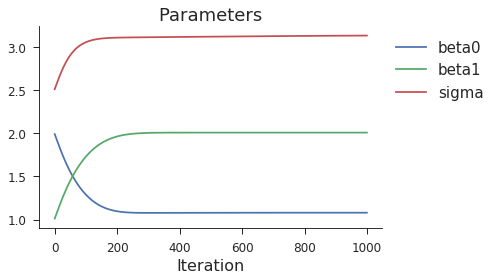

In [8]:
history.plot(title='Parameters', figsize=(7, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

## Classification

In [9]:
dim = 100 # number of x dimensions (number of series)

In [10]:
# construct model symbolically as a graph (of placeholders, variables, and operations)
logit_graph = tf.Graph()
with logit_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, dim), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')

    # these are symbols representing our regression coefficients
    beta0 = tf.Variable(-10.0, dtype=tf.float64, name='beta0')
    beta1 = tf.Variable(0.5*np.ones(dim), dtype=tf.float64, name='beta1')

    # without cheating (divided by N)
    logits = beta0 + tf.squeeze(tf.matmul(x, tf.expand_dims(beta1, 1)))
    lell = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
    like = tf.reduce_mean(lell)
    
    # sigmoid_cross_entropy avoids overflow and is almost equivalent to:
    # prob = 1/(1+tf.exp(-logits))
    # lell = -(y*tf.log(prob)+(1-y)*tf.log(1-prob))
    
    # coefficient distribution
    b1avg = tf.reduce_mean(beta1)
    b1std = tf.sqrt(tf.reduce_mean(beta1**2)-b1avg**2)

    # prediction
    probab = tf.sigmoid(logits)
    predict = tf.cast(logits >= 0.0, dtype=tf.float64) # point prediction in {0,1}
    predavg = tf.reduce_mean(predict)

    # fit assessment
    bool_mean = lambda z: tf.reduce_mean(tf.cast(z, dtype=tf.float64))
    accuracy = bool_mean(tf.equal(predict, y))
    false_pos = bool_mean(tf.equal(predict, 1)&tf.equal(y, 0))
    false_neg = bool_mean(tf.equal(predict, 0)&tf.equal(y, 1))

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(like)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [12]:
def logistic_regression(x_data, y_data, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    history = []
    params = [beta0, b1avg, b1std, accuracy, false_pos, false_neg]
    names = ['beta0', 'b1avg', 'b1std', 'accuracy', 'false_pos', 'false_neg']

    # map real data into placeholders
    data = {x: x_data, y: y_data}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(data, batch_size):
            minn.run(feed_dict=batch)
        history.append(sess.run(params, feed_dict=data))

    # turn history into dataframe
    history = pd.DataFrame(history, columns=names)
    
    # return results
    return history

### Linear Data

In [13]:
# simple hyperplane model
true_beta0 = 0.0
true_beta1 = 1.0*np.ones(dim)

In [14]:
N = 10000
space = np.random.randn(N, dim)
categ = (true_beta0 + np.dot(space, true_beta1) + np.random.logistic(size=N) > 0).astype(np.float64)
print(np.mean(categ))

0.4973


In [15]:
sess = tf.Session(graph=logit_graph)
with sess.as_default():
    history = logistic_regression(space, categ, K=100)
    est_beta0 = beta0.eval()
    est_beta1 = beta1.eval()
print(f'beta0 = {est_beta0}')
print(f'b1avg = {np.mean(est_beta1)}')
print(f'b1std = {np.std(est_beta1)}')

beta0 = 0.02858873389758191
b1avg = 0.9974303862270807
b1std = 0.054859431035599


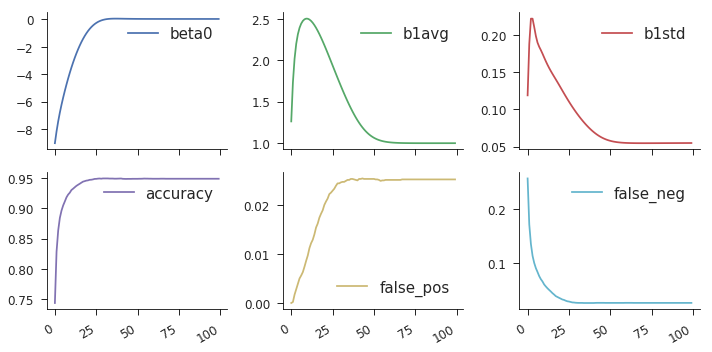

In [16]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

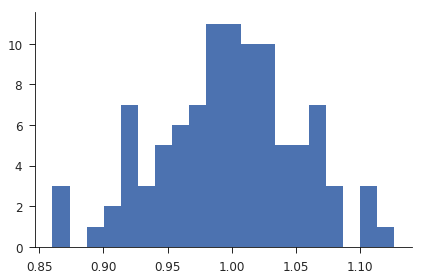

In [17]:
plt.hist(est_beta1, bins=20);

In [18]:
# look at out of sample properties (validation accuracy)
val_space = np.random.randn(N, dim)
val_categ = (true_beta0 + np.dot(val_space, true_beta1) + np.random.logistic(size=N) > 0).astype(np.float64)
val_data = {x: val_space, y: val_categ}
with sess.as_default():
    print('validation')
    print(f'predavg = {predavg.eval(feed_dict=val_data)}')
    print(f'accuracy  = {accuracy.eval(feed_dict=val_data)}')
    print(f'false_pos = {false_pos.eval(feed_dict=val_data)}')
    print(f'false_neg = {false_neg.eval(feed_dict=val_data)}')

validation
predavg = 0.4946
accuracy  = 0.9419
false_pos = 0.0295
false_neg = 0.0286


### Non-linear data

In [19]:
N = 1000
space = np.random.randn(N, dim)
categ = (np.sqrt(np.sum((space)**2, axis=1)) < np.sqrt(dim)).astype(np.float64)
print(np.mean(categ))

0.513


In [20]:
sess = tf.Session(graph=logit_graph)
with sess.as_default():
    history = logistic_regression(space, categ, K=300)
    est_beta0 = beta0.eval()
    est_beta1 = beta1.eval()
print(f'beta0 = {est_beta0}')
print(f'b1avg = {np.mean(est_beta1)}')
print(f'b1std = {np.std(est_beta1)}')

beta0 = 0.08736793357832615
b1avg = 0.020520120756741173
b1std = 0.0727949874173758


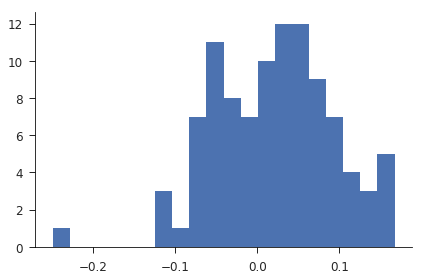

In [21]:
plt.hist(est_beta1, bins=20);

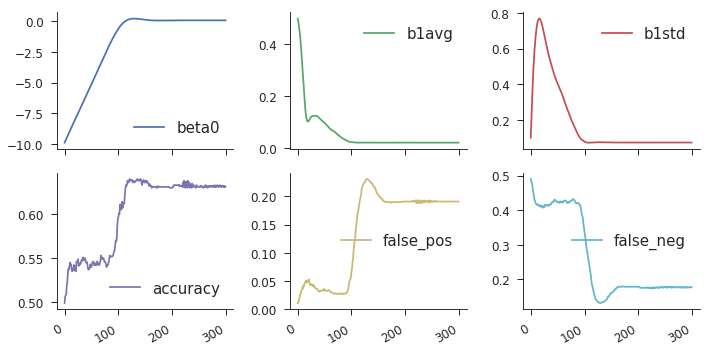

In [22]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

In [23]:
# look at out of sample properties (validation accuracy)
val_space = np.random.randn(N, dim)
val_categ = (np.sqrt(np.sum(val_space**2, axis=1)) < np.sqrt(dim)).astype(np.float64)
val_data = {x: val_space, y: val_categ}
with sess.as_default():
    print('validation')
    print(f'predavg = {predavg.eval(feed_dict=val_data)}')
    print(f'accuracy  = {accuracy.eval(feed_dict=val_data)}')
    print(f'false_pos = {false_pos.eval(feed_dict=val_data)}')
    print(f'false_neg = {false_neg.eval(feed_dict=val_data)}')

validation
predavg = 0.574
accuracy  = 0.483
false_pos = 0.292
false_neg = 0.225


### Neural Networks

In [24]:
N = 10000
hill_func = lambda dat: (dat[:, 1] >= 2.5*dat[:, 0]*(1-dat[:, 0])).astype(np.float64)
# hill_func = lambda dat: (dat[:, 1] + 0.2*np.random.randn(dat.shape[0]) >= 2.5*dat[:, 0]*(1-dat[:, 0])).astype(np.float64)

train_space = np.random.rand(N, 2)
train_categ = hill_func(train_space)

valid_space = np.random.rand(1000, 2)
valid_categ = hill_func(valid_space)

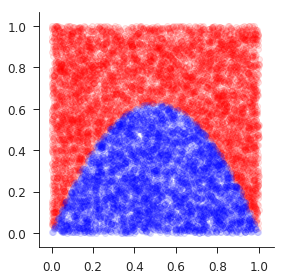

In [25]:
red_space = train_space[train_categ==1, :]
blue_space = train_space[train_categ==0, :]
fig, ax = plt.subplots()
ax.scatter(red_space[:, 0], red_space[:, 1], alpha=0.1, color='red');
ax.scatter(blue_space[:, 0], blue_space[:, 1], alpha=0.1, color='blue');
plt.axis('square');

In [26]:
# number of hidden units
hid = 2

# construct model symbolically as a graph (of placeholders, variables, and operations)
neural_graph = tf.Graph()
with neural_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, 2), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')

    # these are symbols representing our network weights
    W0 = tf.Variable(tf.random_normal((2, hid), dtype=tf.float64), name='weight0')
    b0 = tf.Variable(tf.random_normal((1, hid), dtype=tf.float64), name='bias0')

    W1 = tf.Variable(tf.random_normal((hid, 1), dtype=tf.float64), name='weight1')
    b1 = tf.Variable(tf.random_normal((1, 1), dtype=tf.float64), name='bias1')

    # two layer neural network, RELU + logits
    hidden = tf.nn.sigmoid(tf.matmul(x, W0) + b0)
    logits = tf.squeeze(tf.matmul(hidden, W1) + b1)
    
    # without cheating (divided by N)
    lell = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
    like = tf.reduce_mean(lell)

    # prediction
    probab = tf.sigmoid(logits)
    predict = tf.cast(logits >= 0.0, dtype=tf.float64) # point prediction in {0,1}
    predavg = tf.reduce_mean(predict)

    # fit assessment
    bool_mean = lambda z: tf.reduce_mean(tf.cast(z, dtype=tf.float64))
    accuracy = bool_mean(tf.equal(predict, y))
    false_pos = bool_mean(tf.equal(predict, 1)&tf.equal(y, 0))
    false_neg = bool_mean(tf.equal(predict, 0)&tf.equal(y, 1))

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(like)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [27]:
def neural_regression(train_x, train_y, valid_x, valid_y, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    train_hist = []
    valid_hist = []
    params = [accuracy, false_pos, false_neg]
    names = ['accuracy', 'false_pos', 'false_neg']

    # map real data into placeholders
    train_data = {x: train_x, y: train_y}
    valid_data = {x: valid_x, y: valid_y}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(train_data, batch_size):
            minn.run(feed_dict=batch)
            pass
        train_hist.append(sess.run(params, feed_dict=train_data))
        valid_hist.append(sess.run(params, feed_dict=valid_data))

    # turn history into dataframe
    history = pd.concat([
        pd.DataFrame(train_hist, columns=names).add_prefix('train_'),
        pd.DataFrame(valid_hist, columns=names).add_prefix('valid_')
    ], axis=1)
    
    # return results
    return history

In [28]:
sess = tf.Session(graph=neural_graph)
with sess.as_default():
    history = neural_regression(train_space, train_categ, valid_space, valid_categ, K=200)
history.iloc[-1]

train_accuracy     0.9796
train_false_pos    0.0061
train_false_neg    0.0143
valid_accuracy     0.9770
valid_false_pos    0.0080
valid_false_neg    0.0150
Name: 199, dtype: float64

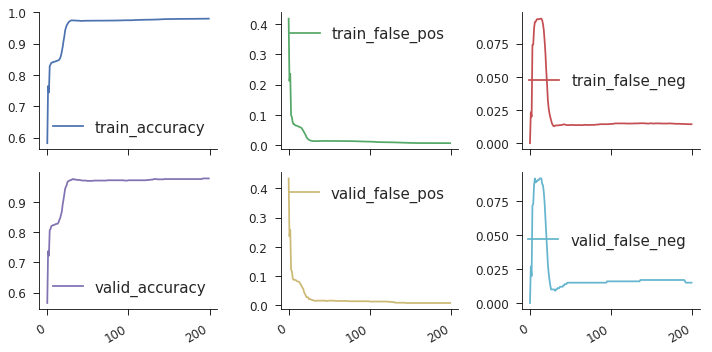

In [29]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

In [30]:
# construct uniform grid over (x, y)
N = 100
test_grid = np.mgrid[0:1:N*1j,0:1:N*1j].reshape((2, -1)).T

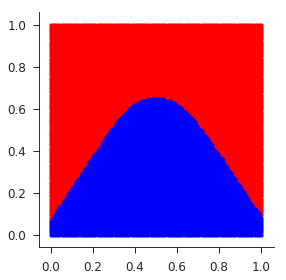

In [31]:
with sess.as_default():
    test_pred = predict.eval(feed_dict={x: test_grid}).astype(np.bool)
    
test_red = test_grid[test_pred, :]
test_blue = test_grid[~test_pred, :]

fig, ax = plt.subplots()
ax.scatter(test_red[:, 0], test_red[:, 1], color='red', s=10);
ax.scatter(test_blue[:, 0], test_blue[:, 1], color='blue', s=10);
plt.axis('square');

[23.70928986 23.58332462]
-16.045364141406846


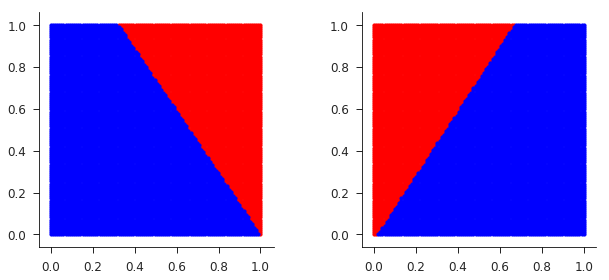

In [32]:
with sess.as_default():
    test_hidden = (hidden.eval(feed_dict={x: test_grid})>=0.5).astype(np.bool)
    test_W1 = W1.eval().squeeze()
    test_b1 = b1.eval().squeeze()

print(test_W1)
print(test_b1)

# normalize by layer weight sign in final aggregation
layer_sign = test_W1 < 0
layer_mask0 = layer_sign[0] ^ test_hidden[:, 0]
layer_mask1 = layer_sign[1] ^ test_hidden[:, 1]

# get hidden outputs
test0_red = test_grid[layer_mask0, :]
test0_blue = test_grid[~layer_mask0, :]
test1_red = test_grid[layer_mask1, :]
test1_blue = test_grid[~layer_mask1, :]

# plot both
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.scatter(test0_red[:, 0], test0_red[:, 1], color='red', s=10);
ax0.scatter(test0_blue[:, 0], test0_blue[:, 1], color='blue', s=10);
ax1.scatter(test1_red[:, 0], test1_red[:, 1], color='red', s=10);
ax1.scatter(test1_blue[:, 0], test1_blue[:, 1], color='blue', s=10);
ax0.axis('square');
ax1.axis('square');

## Getting Fancy

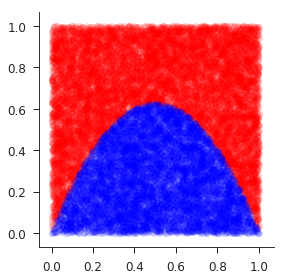

In [33]:
N = 20000
hill_func = lambda dat: (dat[:, 1] >= 2.5*dat[:, 0]*(1-dat[:, 0])).astype(np.float64)
train_space = np.random.rand(N, 2)
train_categ = hill_func(train_space)

red_space = train_space[train_categ==1, :]
blue_space = train_space[train_categ==0, :]
fig, ax = plt.subplots()
ax.scatter(red_space[:, 0], red_space[:, 1], alpha=0.1, color='red');
ax.scatter(blue_space[:, 0], blue_space[:, 1], alpha=0.1, color='blue');
plt.axis('square');

In [34]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2, activation=tf.nn.softmax),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_space, train_categ, epochs=10);

Epoch 1/10
20000/20000 [==============================] - 2s 122us/step - loss: 0.6639 - acc: 0.5800
Epoch 2/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.5883 - acc: 0.6704
Epoch 3/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.4768 - acc: 0.8077
Epoch 4/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.4008 - acc: 0.8294
Epoch 5/10
20000/20000 [==============================] - 2s 114us/step - loss: 0.3656 - acc: 0.8337
Epoch 6/10
20000/20000 [==============================] - 2s 115us/step - loss: 0.3505 - acc: 0.8365
Epoch 7/10
20000/20000 [==============================] - 2s 115us/step - loss: 0.3438 - acc: 0.8389
Epoch 8/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.3402 - acc: 0.8388
Epoch 9/10
20000/20000 [==============================] - 2s 114us/step - loss: 0.3381 - acc: 0.8402
Epoch 10/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.3365 - a

In [39]:
valid_space = np.random.rand(N, 2)
valid_categ = hill_func(valid_space)

valid_pred = model.predict(valid_space).argmax(axis=1)
np.mean(valid_pred==valid_categ)

0.83975

## Overfitting

In [52]:
from sklearn.utils import shuffle

In [84]:
# parameters
N = 1000 # number of series
T = 10 # total time length
L = 4 # sequence length
K = T - L # number of subseries

In [85]:
# generate overlapping sequences
def generate_sequences(vec):
    series = np.stack([vec[:, i:i+L] for i in range(K)], axis=-1).swapaxes(1, 2).reshape((N*K, -1))
    target = vec[:, L:].reshape((N*K,))
    return series, target

In [86]:
# generate training data
train_return = np.random.randn(N, T)
train_series, train_target = generate_sequences(train_return)

# generate validation data
valid_return = np.random.randn(N, T)
valid_series, valid_target = generate_sequences(valid_return)

# sample output
print(np.hstack([train_series, train_target[:, None]])[:10, :])

# shuffle samples
train_series, train_target = shuffle(train_series, train_target)
valid_series, valid_target = shuffle(valid_series, valid_target)

[[-0.13314431  1.11339184  1.14776224  0.34164339  0.37622947]
 [ 1.11339184  1.14776224  0.34164339  0.37622947  0.14040023]
 [ 1.14776224  0.34164339  0.37622947  0.14040023 -2.22562145]
 [ 0.34164339  0.37622947  0.14040023 -2.22562145 -1.01775544]
 [ 0.37622947  0.14040023 -2.22562145 -1.01775544 -0.33754964]
 [ 0.14040023 -2.22562145 -1.01775544 -0.33754964 -0.50205678]
 [ 1.40428834  0.82090116  0.5637609  -0.56534283  0.56531744]
 [ 0.82090116  0.5637609  -0.56534283  0.56531744  0.08597277]
 [ 0.5637609  -0.56534283  0.56531744  0.08597277  0.17256289]
 [-0.56534283  0.56531744  0.08597277  0.17256289 -0.98447251]]


In [94]:
# number of hidden units
hid = 5

# construct model symbolically as a graph (of placeholders, variables, and operations)
trader_graph = tf.Graph()
with trader_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, L), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')

    # these are symbols representing our network weights
    W0 = tf.Variable(tf.random_normal((L, hid), dtype=tf.float64), name='weight0')
    b0 = tf.Variable(tf.random_normal((1, hid), dtype=tf.float64), name='bias0')

    W1 = tf.Variable(tf.random_normal((hid, 1), dtype=tf.float64), name='weight1')
    b1 = tf.Variable(tf.random_normal((1, 1), dtype=tf.float64), name='bias1')

    # two layer neural network, RELU + logits
    hidden = tf.nn.sigmoid(tf.matmul(x, W0) + b0)
    logits = tf.squeeze(tf.matmul(hidden, W1) + b1)
    recom = tf.sigmoid(logits)
    
    # without cheating (divided by N)
    retn = recom*y
    totr = tf.reduce_mean(retn)

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(-totr)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [95]:
def neural_trader(train_x, train_y, valid_x, valid_y, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    train_hist = []
    valid_hist = []
    params = [totr]
    names = ['return']

    # map real data into placeholders
    train_data = {x: train_x, y: train_y}
    valid_data = {x: valid_x, y: valid_y}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(train_data, batch_size):
            minn.run(feed_dict=batch)
            pass
        train_hist.append(sess.run(params, feed_dict=train_data))
        valid_hist.append(sess.run(params, feed_dict=valid_data))

    # turn history into dataframe
    history = pd.concat([
        pd.DataFrame(train_hist, columns=names).add_prefix('train_'),
        pd.DataFrame(valid_hist, columns=names).add_prefix('valid_')
    ], axis=1)
    
    # return results
    return history

train_return    0.037121
valid_return   -0.009527
Name: 199, dtype: float64


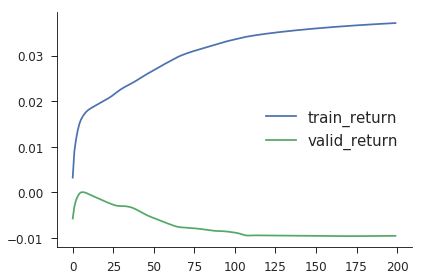

In [96]:
sess = tf.Session(graph=trader_graph)
with sess.as_default():
    history = neural_trader(train_series, train_target, valid_series, valid_target, K=200)
print(history.iloc[-1])
history.plot();

## With Momentum

In [60]:
momentum = 0.2

In [61]:
# generate training data
train_mean = momentum*np.random.randn(N)
train_return = train_mean[:, None] + np.random.randn(N, T)
train_series, train_target = generate_sequences(train_return)

# generate validation data
valid_mean = momentum*np.random.randn(N)
valid_return = valid_mean[:, None] + np.random.randn(N, T)
valid_series, valid_target = generate_sequences(valid_return)

# sample output
print(np.hstack([train_series, train_target[:, None]])[:10, :])

# shuffle samples
train_series, train_target = shuffle(train_series, train_target)
valid_series, valid_target = shuffle(valid_series, valid_target)

[[ 1.62430323 -0.12699627  0.99785398 -0.1570454   1.34129477]
 [-0.12699627  0.99785398 -0.1570454   1.34129477  0.39689428]
 [ 0.99785398 -0.1570454   1.34129477  0.39689428  1.31231706]
 [-0.1570454   1.34129477  0.39689428  1.31231706  1.93588962]
 [ 1.34129477  0.39689428  1.31231706  1.93588962  1.41755242]
 [ 0.39689428  1.31231706  1.93588962  1.41755242  0.01898902]
 [ 1.31231706  1.93588962  1.41755242  0.01898902  0.64130531]
 [ 1.93588962  1.41755242  0.01898902  0.64130531  0.11995194]
 [ 1.41755242  0.01898902  0.64130531  0.11995194  0.71792201]
 [ 0.01898902  0.64130531  0.11995194  0.71792201  1.38571534]]


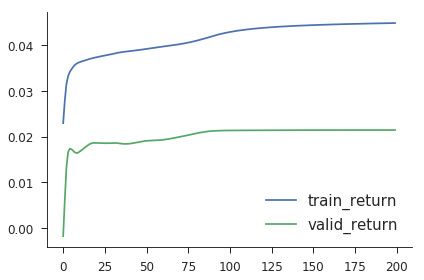

In [62]:
sess = tf.Session(graph=trader_graph)
with sess.as_default():
    history = neural_trader(train_series, train_target, valid_series, valid_target, K=200)
history.plot();

## Dropout

In [97]:
hid = 5 # number of hidden units
keep0 = 0.5 # default keep probability

In [98]:
# construct model symbolically as a graph (of placeholders, variables, and operations)
dropout_graph = tf.Graph()
with dropout_graph.as_default():
    # these are where we'll "feed" batches of data in
    x = tf.placeholder(dtype=tf.float64, shape=(None, L), name='x')
    y = tf.placeholder(dtype=tf.float64, shape=(None,), name='y')
    keep_prob = tf.placeholder_with_default(np.float64(keep0), shape=(), name='keep_prob')

    # these are symbols representing our network weights
    W0 = tf.Variable(tf.random_normal((L, hid), dtype=tf.float64), name='weight0')
    b0 = tf.Variable(tf.random_normal((1, hid), dtype=tf.float64), name='bias0')

    W1 = tf.Variable(tf.random_normal((hid, 1), dtype=tf.float64), name='weight1')
    b1 = tf.Variable(tf.random_normal((1, 1), dtype=tf.float64), name='bias1')

    # two layer neural network, RELU + logits
    hidden = tf.nn.sigmoid(tf.matmul(x, W0) + b0)
    dropout = tf.nn.dropout(hidden, keep_prob)
    logits = tf.squeeze(tf.matmul(dropout, W1) + b1)
    recom = tf.sigmoid(logits)
    
    # without cheating (divided by N)
    retn = recom*y
    totr = tf.reduce_mean(retn)

    # this is an operation that optimizes an objective function
    opt = tf.train.AdamOptimizer(learning_rate=0.1)
    minn = opt.minimize(-totr)
    
    # this must go at the end!
    init = tf.global_variables_initializer()

In [99]:
def dropout_trader(train_x, train_y, valid_x, valid_y, K=100):
    sess = tf.get_default_session()
    
    # save history of training (the old fashioned way)
    train_hist = []
    valid_hist = []
    params = [totr]
    names = ['return']

    # map real data into placeholders
    train_data = {x: train_x, y: train_y}
    valid_data = {x: valid_x, y: valid_y}
    
    # evaluation feeds
    train_eval = {x: train_x, y: train_y, keep_prob: 1.0}
    valid_eval = {x: valid_x, y: valid_y, keep_prob: 1.0}

    # initialize variables (our coefficients)
    init.run()

    # run for a fixed period and hope for convergence
    for i in range(K):
        for batch in batch_dict(train_data, batch_size):
            minn.run(feed_dict=batch)
            pass
        train_hist.append(sess.run(params, feed_dict=train_eval))
        valid_hist.append(sess.run(params, feed_dict=valid_eval))

    # turn history into dataframe
    history = pd.concat([
        pd.DataFrame(train_hist, columns=names).add_prefix('train_'),
        pd.DataFrame(valid_hist, columns=names).add_prefix('valid_')
    ], axis=1)
    
    # return results
    return history

train_return    0.022321
valid_return   -0.000405
Name: 199, dtype: float64


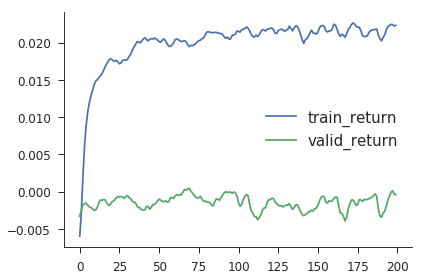

In [100]:
sess = tf.Session(graph=dropout_graph)
with sess.as_default():
    history = dropout_trader(train_series, train_target, valid_series, valid_target, K=200)
print(history.iloc[-1])
history.plot();

## Text Analysis

In [114]:
import os
import re
import json
import time
import html

In [115]:
import sklearn.feature_extraction.text as fe
from sklearn.model_selection import train_test_split
import tflearn
from tflearn.data_utils import to_categorical

In [116]:
def clean_tweet(text):
    text = text.lower().strip()

    # odd subs
    text = re.sub(r'’', '\'', text)
    text = re.sub(r'—', '-', text)

    # urls
    text = re.sub(r'\bhttps?://[\S]*\b', r' ', text)
    text = html.unescape(text)

    # acronyms
    text = re.sub(r'\.{2,}', r'.', text)
    text = re.sub(r'(\S)\.(\S)\.', r'\1\2', text)
    text = re.sub(r'(\S)\.(\S)\.(\S)\.', r'\1\2\3', text)

    # control chars
    text = re.sub(r'([!\.&,])', r' \1 ', text)
    text = re.sub(r'[^ a-z0-9#@!\.&,\']', r' ', text)
    text = re.sub(r'[0-9\']', r'', text)

    # clean up
    text = re.sub(r' {2,}', r' ', text)
    text = text.strip()

    # combine
    return text

In [117]:
trump_dir = '/media/Liquid/data/tweets/trump_tweet_data_archive'
tweets16 = pd.read_json(os.path.join(trump_dir, 'condensed_2016.json'))
tweets17 = pd.read_json(os.path.join(trump_dir, 'condensed_2017.json'))
tweets = pd.concat([tweets16, tweets17])

rt_mark = tweets['text'].apply(lambda s: s.startswith('"@') or s.startswith('rt'))
tweets = tweets[(~tweets['is_retweet'])&(~rt_mark)&tweets['in_reply_to_user_id_str'].isnull()]
tweets['isource'] = tweets['source'].map({'Twitter for iPhone': 0, 'Twitter for Android': 1})
tweets = tweets.dropna(subset=['isource'])
tweets['isource'] = tweets['isource'].astype(np.int)
tweets['clean_text'] = tweets['text'].apply(clean_tweet)

In [118]:
corpus = list(tweets['clean_text'])
categ = to_categorical(tweets['isource'].values, 2)
print(len(corpus))

3460


In [119]:
tfidf = fe.TfidfVectorizer()
counts = tfidf.fit_transform(corpus).todense()
n_twt, n_wrd = counts.shape

In [120]:
(train_x, valid_x, train_y, valid_y) = train_test_split(counts, categ, test_size=0.1)

In [121]:
def generate_nn(n_wrd, nn_size, dropout):
    net = tflearn.input_data([None, n_wrd])
    net = tflearn.fully_connected(net, nn_size, activation='softmax')
    net = tflearn.dropout(net, 1-dropout)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')
    model = tflearn.DNN(net, clip_gradients=0.0, tensorboard_verbose=1,
        tensorboard_dir='/tmp/tflearn_logs/neural', checkpoint_path='checkpoints/neural')
    return model

In [122]:
model = generate_nn(n_wrd, 128, 0.5)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [123]:
run_id = 'neural_%s' % time.strftime('%Y_%m%d_%H%M')
model.fit(train_x, train_y, validation_set=(valid_x, valid_y),
          show_metric=True, n_epoch=25, run_id=run_id)

Training Step: 1224  | total loss: 0.37220 | time: 1.167s
| Adam | epoch: 025 | loss: 0.37220 - acc: 0.8945 -- iter: 3072/3114
Training Step: 1225  | total loss: 0.37137 | time: 2.198s
| Adam | epoch: 025 | loss: 0.37137 - acc: 0.8956 | val_loss: 0.42135 - val_acc: 0.8439 -- iter: 3114/3114
--
INFO:tensorflow:/media/Liquid/work/data_science/checkpoints/neural-1225 is not in all_model_checkpoint_paths. Manually adding it.


In [126]:
valid_prob = model.predict(valid_x)
valid_pred = np.array(valid_prob).argmax(axis=1)
valid_bin = np.array(valid_y).argmax(axis=1)
valid_acc = (valid_bin==valid_pred).mean()

In [127]:
all_prob = model.predict(counts)
android_prob = all_prob[:, 1]
androidy = list(tweets['text'].iloc[android_prob.argsort()[::-1]])

In [132]:
print('\n\n'.join(androidy[:5]))

Only reason the hacking of the poorly defended DNC is discussed is that the loss by the Dems was so big that they are totally embarrassed!

It was just announced-by sources-that no charges will be brought against Crooked Hillary Clinton. Like I said, the system is totally rigged!

I am not just running against Crooked Hillary Clinton, I am running against the very dishonest and totally biased media - but I will win!

Hillary and the Dems were never going to beat the PASSION of my voters. They saw what was happening in the last two weeks before the......

Very sad that a person who has made so many mistakes, Crooked Hillary Clinton, can put out such false and vicious ads with her phony money!


In [144]:
print('\n\n'.join(androidy[-5:]))

THANK YOU, AMERICA! #Trump2016
#MakeAmericaGreatAgain 
https://t.co/09hTbBgPHf https://t.co/uJnmDnvkUv

Thank you, America!
#MakeAmericaGreatAgain #Trump2016 https://t.co/7xxWD0au9H

THANK YOU AMERICA! 
#MakeAmericaGreatAgain #Trump2016 https://t.co/TRrdR0nlpM

Thank you America! #Trump2016
#MakeAmericaGreatAgain https://t.co/8B0J8Xt3dh

THANK YOU!  
#MakeAmericaGreatAgain #Trump2016
https://t.co/nvgOPoo5qf https://t.co/0JCjfbcpJZ
